In [1]:
using Plots
using Distributions
using Turing
using PrettyTables, DataFrames
using StatsBase

In [2]:
x = distance = Vector{Float64}([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
n = tries = Vector{Int64}([1433, 694, 455,353,272,256,240,217,200,237,202,192,174,167,201,195,191,147,152])
y = success = Vector{Float64}([1346,577,337,208,149,136,111,69,67,75,52,46,54,28,27,31,33,20,24])

19-element Vector{Float64}:
 1346.0
  577.0
  337.0
  208.0
  149.0
  136.0
  111.0
   69.0
   67.0
   75.0
   52.0
   46.0
   54.0
   28.0
   27.0
   31.0
   33.0
   20.0
   24.0

we are attempting to predict the probability of success given the distance from the hole. Thus, we need to transform the data to explore a bit. Calculating the probability using sucess/tries and the error with formula:

\begin{equation}
    \sqrt{\hat{p}_j(1-\hat{p}_j)/n_j}
\end{equation}

In [3]:
pj = y ./ n
error = @. sqrt((pj * (1 - pj) / n));

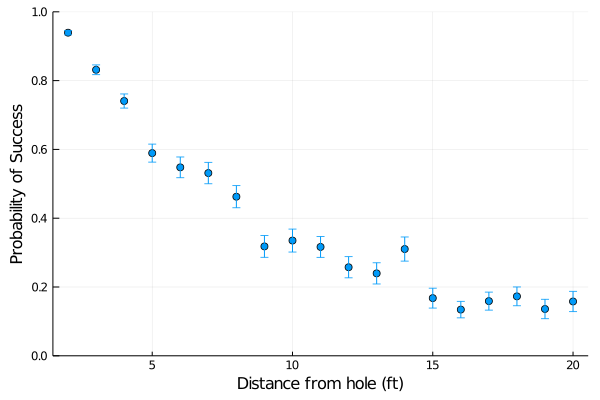

In [4]:
# plot out the error
scatter(
  x, pj,
  yerror= error,
  legend = false,
  ylim = (0, 1),
  ylab = "Probability of Success",
  xlab = "Distance from hole (ft)")

As the relationship suggest, as distance grows the probability of success decreases. To model this we are going to use logistic regression and a binomial likelihood for the classification. We will take two prior parameters \beta and \epsilon with mean 0 and standard deviation 1. This can be represented as:

\begin{equation}
   y_j \sim binomial(n_j, logit^{-1}(a+bx_j)), \quad for \quad j=1,.....J.
\end{equation}


\begin{equation}
    y \sim Binomial(n, p)
\end{equation}

\begin{equation}
    p \sim logistic(\alpha, X\cdot\beta)
\end{equation}


\begin{equation}
   \alpha \sim Normal(0, 1)
\end{equation}


\begin{equation}
   \beta \sim Normal(0, 1)
\end{equation}

here we will consider $\epsilon$ as $\alpha$

In [5]:
using StatsFuns: logistic

@model model(x,y,n,J) = begin
  # parameters
  ϵ ~ Normal(0, 1)
  β ~ Normal(0, 1)

  # model
  for i in 1:J
    p = logistic(ϵ + β * x[i])
    y[i] ~ Binomial(n[i], p)
  end
end

model (generic function with 1 method)

In [9]:
chn = sample(model(x, y, n, length(x)), NUTS(), MCMCThreads(), 4000, 4); #running 4 threads and 4000 samples

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/itachiuchiha/.julia/packages/AbstractMCMC/oou1a/src/sample.jl:253
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/itachiuchiha/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/itachiuchiha/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/itachiuchiha/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /home/itachiuchiha/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
┌ Wa

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/itachiuchiha/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/itachiuchiha/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/itachiuchiha/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/itachiuchiha/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ

In [10]:
chn

Chains MCMC chain (4000×14×4 Array{Float64, 3}):

Iterations        = 1:1:4000
Number of chains  = 4
Samples per chain = 4000
parameters        = β, ϵ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

           β   -0.2570    0.0067     0.0001    0.0001   4413.2704    1.0001
           ϵ    2.2470    0.0586     0.0005    0.0008   4343.8633    1.0002

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           β   -0.2705   -0.2615   -0.2570   -0.2524   -0.2440
           ϵ    2.1333    2.2079    2.2460    2.2864    2.3643


┌ Warning: timestamp of type Nothing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Nothing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Nothing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Nothing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/pack

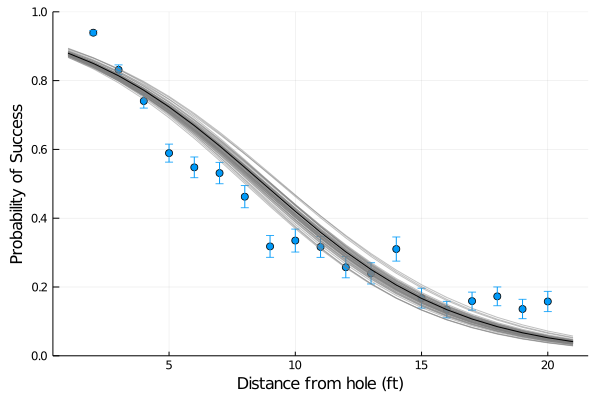

In [15]:
ϵ = mean(chn[:ϵ])
β = mean(chn[:β])

# # iterator for distance from hole calcs
xrng = 1:1:21
post_lines = [logistic(ϵ + β * x) for x = xrng]

# 50 draws from the posterior
ϵ_samples = sample(chn[:ϵ], 100)
β_samples = sample(chn[:β], 100)

post_samp = [logistic(ϵ_samples[i] + β_samples[i] * x) for x = xrng, i = 1:50]

plot!(post_samp, alpha = 0.5, color = :gray) # add uncertainty samples
plot!(post_lines, color = :black) # add mean

Here, we can see the posterior prediction by our model over a set of data. Even though in the extrapolations, it cannot do better, however, in the mid values it is pretty much within the range of data. From our chains, it is hard to say our overall uncertainty, because for each values we do have different uncercainty provided by the curve, however, for assumptions we can say 0.003476837865174288 or +- half of it. This model can be said to be decent and does fit the pattern